In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import urllib3
urllib3.disable_warnings()

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [5]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [6]:
print(ds_info.features["label"].num_classes)
print(ds_info.features["label"].names)

2
['cat', 'dog']


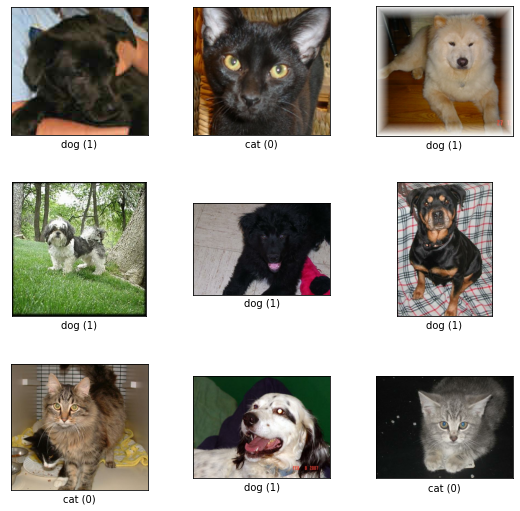

In [7]:
fig = tfds.show_examples(ds_train, ds_info)

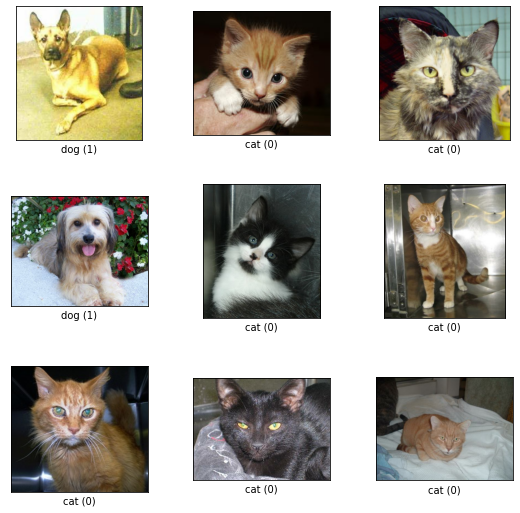

In [8]:
fig = tfds.show_examples(ds_test, ds_info)

In [10]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [11]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [12]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1,          
               activation='relu'):
    
    # convolutional layer    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)

    # Batch Normalization
    x = keras.layers.BatchNormalization()(x)

    # Relu Activation layer
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [13]:
def build_resnet_or_plain_block(input_shape, 
                                num_cnn=3, 
                                channel=64, 
                                block_num=0,
                                is_50 = True,
                                is_skip_connection = True):
   
    x = input_shape

    # ResNet-34(skip connection 존재)
    if not is_50 and is_skip_connection :
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
            
    
    # ResNet-50(skip connection 존재)
    elif is_50 and is_skip_connection:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # Plain-34(skip connection 없음)
    elif not is_50 and not is_skip_connection :
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))
    
    # Plain-50(skip connection 없음)
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1)) 
 
    return x

In [14]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 is_skip_connection = True,
                 activation='sigmoid',
                 name = 'ResNet-50'):
    
    assert len(channel_list) == len(num_cnn_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # ResNet 34와 ResNet 50의 공통된 앞 부분
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual 블록을 생성합니다.
    # ResNet 34의 Residual 블록
    if not is_50 and is_skip_connection:
        for block_num, (num_cnn_34, channel_34) in enumerate(zip(num_cnn_list, channel_list)):
            x = build_resnet_or_plain_block(x, 
                               num_cnn=num_cnn_34, 
                               channel=channel_34, 
                               block_num=block_num, 
                               is_50=is_50,
                               is_skip_connection=is_skip_connection)    
    
    # ResNet 50의 Residual 블록
    elif is_50 and is_skip_connection:
        for block_num, (num_cnn_50, channel_50) in enumerate(zip(num_cnn_list, channel_list)):
            x = build_resnet_or_plain_block(x, 
                               num_cnn=num_cnn_50, 
                               channel=channel_50, 
                               block_num=block_num, 
                               is_50=is_50,
                               is_skip_connection=is_skip_connection)
            

    # Plain 34의 블록
    elif not is_50 and not is_skip_connection:
        for block_num, (num_cnn_34, channel_34) in enumerate(zip(num_cnn_list, channel_list)):
            x = build_resnet_or_plain_block(x, 
                               num_cnn=num_cnn_34, 
                               channel=channel_34, 
                               block_num=block_num, 
                               is_50=is_50,
                               is_skip_connection=is_skip_connection)            
    # Plain 50의 블록
    else:
        for block_num, (num_cnn_50, channel_50) in enumerate(zip(num_cnn_list, channel_list)):
            x = build_resnet_or_plain_block(x, 
                               num_cnn=num_cnn_50, 
                               channel=channel_50, 
                               block_num=block_num, 
                               is_50=is_50,
                               is_skip_connection=is_skip_connection)      

    
    x = keras.layers.AveragePooling2D(padding='same')(x)
    x = keras.layers.Flatten(name='flatten')(x)
    x = keras.layers.Dense(num_classes,
                           activation=activation,
                           kernel_initializer='he_normal',
                           name='fc1000')(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name = name)
    
    return model

In [15]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False, is_skip_connection = True, name = 'ResNet-34')
resnet_34.summary()

Model: "ResNet-34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
__________________________________________________________________________________________

In [16]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True, is_skip_connection = True)
resnet_50.summary()

Model: "ResNet-50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
__________________________________________________________________________________________

In [17]:
plain_34 = build_resnet(input_shape=(32,32,3), is_50=False, is_skip_connection = False, name = 'Plain-34')
plain_34.summary()

Model: "Plain-34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
activation_82 (Activation)   (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 8, 8, 64)          256

In [18]:
plain_50 = build_resnet(input_shape=(32,32,3), is_50 = True, is_skip_connection = False, name = 'Plain-50')
plain_50.summary()

Model: "Plain-50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
activation_115 (Activation)  (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 8, 8, 64)          4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 8, 8, 64)          256

In [19]:
BATCH_SIZE = 32
EPOCH = 10

In [20]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)